<a href="https://colab.research.google.com/github/SavageGinny/AI-python/blob/main/%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ практика 5. Задача регрессии

## **Цель занятия:**
Изучить задачу регрессии, познакомиться с метриками качества, реализовать модель для решения задачи с использованием разных моделей.

## **Задание состоит из следующих частей:**
1. Понимание значимости отбора признаков
2. Обучение регрессии
3. Метирки качества для регресии (только самые важные)
4. Регулязризация

## Задачи для домашки ⏰

1. Выбрать y = непрерывная переменая
2. Разделить на обучающую, тестовую и валидационную выборки
3. Выбрать лучшие признаки для X и выбрать лучший результат
4. Объяснить результаты метрик качества MAE, MSE, R2

**Для 👽**
5. Попробовать модель ```KNeighborsRegressor```, объяснить как работает модель, объяснить результат
6. Попробовать модель ```DecisionTreeRegressor```, объяснить как работает модель, объяснить результат

In [1]:
! pip install pandas scikit-learn seaborn scipy

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
try:
    df = pd.read_csv('/content/pokemon.csv')
except FileNotFoundError:
    df = pd.read_csv('pokemon.csv')

y = df['Total'] # выбираем целевую переменную (количественная)
X = df.drop(['Total', '#', 'Name', 'Type 1', 'Type 2'], axis=1)


In [49]:
X

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,45,49,49,65,65,45,1,False
1,60,62,63,80,80,60,1,False
2,80,82,83,100,100,80,1,False
3,80,100,123,122,120,80,1,False
4,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...
795,50,100,150,100,150,50,6,True
796,50,160,110,160,110,110,6,True
797,80,110,60,150,130,70,6,True
798,80,160,60,170,130,80,6,True


Преобразование категориальных переменных остается без изменений

In [50]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['object']).columns # собираем колонки помеченные как object

# Применяем One-Hot Encoding к категориальным столбцам, исключая первую категорию (drop_first=True)
X = pd.get_dummies(X, columns=category_columns,drop_first=True)


In [51]:
X

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,45,49,49,65,65,45,1,False
1,60,62,63,80,80,60,1,False
2,80,82,83,100,100,80,1,False
3,80,100,123,122,120,80,1,False
4,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...
795,50,100,150,100,150,50,6,True
796,50,160,110,160,110,110,6,True
797,80,110,60,150,130,70,6,True
798,80,160,60,170,130,80,6,True


In [52]:
df_corr_test = X.copy()

# Добавляем целевую переменную в копию данных
df_corr_test['y'] = y
df_corr_test

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,y
0,45,49,49,65,65,45,1,False,318
1,60,62,63,80,80,60,1,False,405
2,80,82,83,100,100,80,1,False,525
3,80,100,123,122,120,80,1,False,625
4,39,52,43,60,50,65,1,False,309
...,...,...,...,...,...,...,...,...,...
795,50,100,150,100,150,50,6,True,600
796,50,160,110,160,110,110,6,True,700
797,80,110,60,150,130,70,6,True,600
798,80,160,60,170,130,80,6,True,680


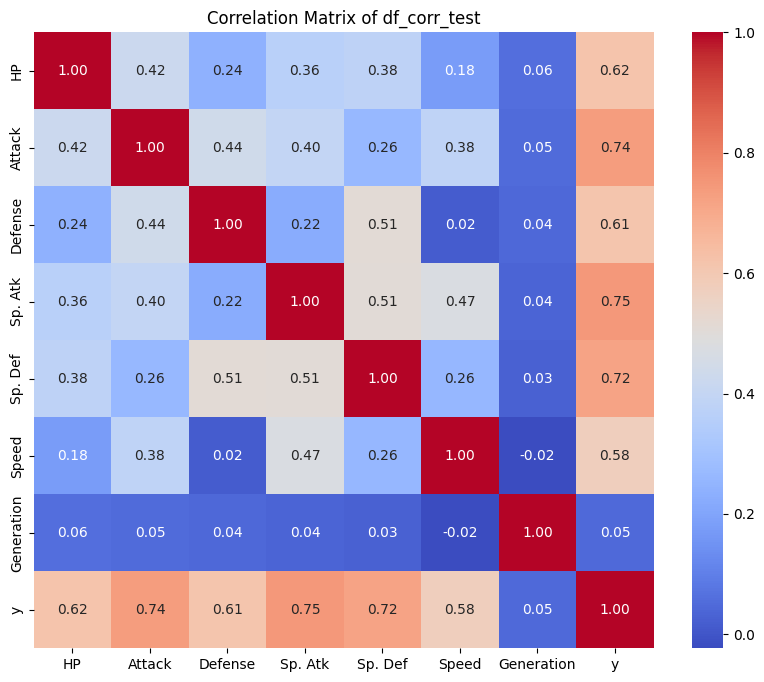

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Предположим, что у вас уже есть DataFrame под названием df_corr_test
# Выводим матрицу корреляции (только для числовых столбцов)
correlation_matrix = df_corr_test.select_dtypes(['int', 'float']).corr()

# Отображаем матрицу корреляции с помощью тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of df_corr_test")
plt.show()


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def resolve_regression(X, y, regularization=None):
    """
    Выполняет регрессию с учетом регуляризации.

    Parameters:
    - X: Входные данные (признаки).
    - y: Целевые значения.
    - regularization: Тип регуляризации ('l1', 'l2', None). Если None, используется обычная линейная регрессия.
    """
    # Разделение данных на обучающую и тестовую выборки (80% / 20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Инициализация модели в зависимости от типа регуляризации
    if regularization == 'l1':
        model = Lasso() # L1-регуляризация (Lasso)
    elif regularization == 'l2':
        model = Ridge() # L2-регуляризация (Ridge)
    else:
        model = LinearRegression() # Линейная регрессия без регуляризации

    # Обучение модели
    model.fit(X_train, y_train)

    # Предсказание на тестовой выборке
    y_pred = model.predict(X_test)

    # Вычисление метрик качества
    mae = mean_absolute_error(y_test, y_pred) # Средняя абсолютная ошибка
    mse = mean_squared_error(y_test, y_pred)  # Средняя квадратичная ошибка
    r2 = r2_score(y_test, y_pred)             # Коэффициент детерминации (R^2)

    # Вывод результатов
    print(f"Regularization: {regularization}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R^2 Score: {r2:.2f}")

    return model, X_train, X_test, y_train, y_test

In [55]:
resolve_regression(X, y)
None # Используем None (оператор ничего не делает) чтобы убрать вывод от return у функции resolve_regression. Пока он нам не нужен и и будет мешать


Regularization: None
Mean Absolute Error (MAE): 0.00
Mean Squared Error (MSE): 0.00
R^2 Score: 1.00


In [56]:
resolve_regression(X[['HP', 'Defense', 'Attack', 'Speed']], y)
None


Regularization: None
Mean Absolute Error (MAE): 33.44
Mean Squared Error (MSE): 2002.37
R^2 Score: 0.85


Теперь попробуем оптимизировать числовые переменные и сделать тоже самое

In [57]:
X

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,45,49,49,65,65,45,1,False
1,60,62,63,80,80,60,1,False
2,80,82,83,100,100,80,1,False
3,80,100,123,122,120,80,1,False
4,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...
795,50,100,150,100,150,50,6,True
796,50,160,110,160,110,110,6,True
797,80,110,60,150,130,70,6,True
798,80,160,60,170,130,80,6,True


In [58]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   HP          800 non-null    int64
 1   Attack      800 non-null    int64
 2   Defense     800 non-null    int64
 3   Sp. Atk     800 non-null    int64
 4   Sp. Def     800 non-null    int64
 5   Speed       800 non-null    int64
 6   Generation  800 non-null    int64
 7   Legendary   800 non-null    bool 
dtypes: bool(1), int64(7)
memory usage: 44.7 KB


Отбор признаков по корреляции

In [59]:
import pandas as pd
import numpy as np

def select_features_correlation(X, y, max_features=5):
    # Вычисляем корреляцию признаков с целевой переменной
    correlation = X.apply(lambda col: np.abs(col.corr(y)))

    # Отбираем top-N признаков с наибольшей корреляцией
    top_features = correlation.nlargest(max_features).index

    # Возвращаем X и y с отобранными признаками
    return X[top_features], y


Отбор признаков с помощью RFE (Recursive Feature Elimination)

In [60]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

def select_features_rfe(X, y, max_features=5):
    # Инициализация модели линейной регрессии
    model = LinearRegression()

    # RFE с указанным количеством признаков
    selector = RFE(model, n_features_to_select=max_features)
    selector = selector.fit(X, y)

    # Отбор признаков
    selected_features = X.columns[selector.support_]

    # Возвращаем X и y с отобранными признаками
    return X[selected_features], y


In [61]:
# Предположим, что у вас есть данные X и y
# Используем отбор на основе корреляции
X_selected_corr, y_selected_corr = select_features_correlation(X, y, max_features=5)

# Используем отбор с помощью RFE
X_selected_rfe, y_selected_rfe = select_features_rfe(X, y, max_features=5)


In [62]:
resolve_regression(X_selected_corr, y_selected_corr)
None

Regularization: None
Mean Absolute Error (MAE): 18.65
Mean Squared Error (MSE): 565.47
R^2 Score: 0.96


In [63]:
resolve_regression(X_selected_rfe, y_selected_rfe)
None

Regularization: None
Mean Absolute Error (MAE): 19.36
Mean Squared Error (MSE): 636.77
R^2 Score: 0.95


Regularization: None
Mean Absolute Error (MAE): 19.36
Mean Squared Error (MSE): 636.77
R^2 Score: 0.95


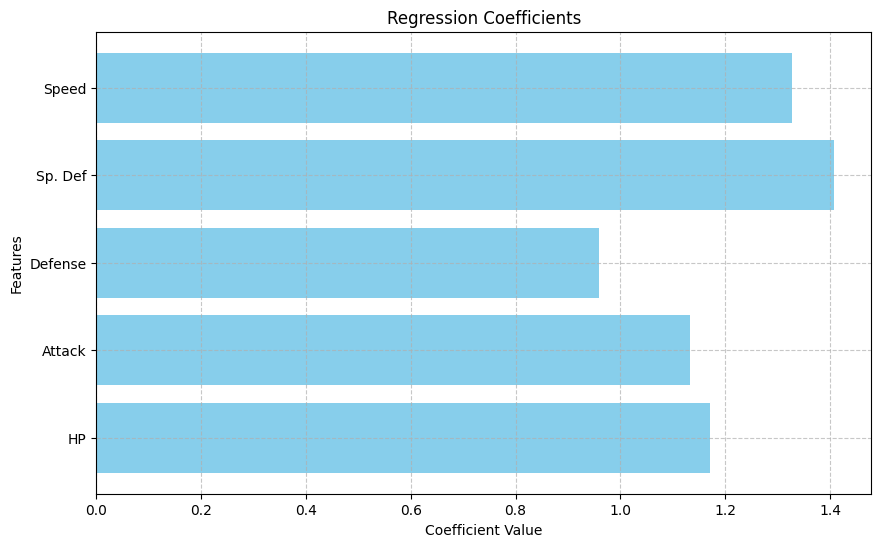

In [64]:
import matplotlib.pyplot as plt

def plot_regression_coefficients(model, feature_names):
    # Извлекаем коэффициенты регрессии
    coefficients = model.coef_

    # Создаем столбчатую диаграмму для визуализации коэффициентов
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, coefficients, color='skyblue')
    plt.xlabel("Coefficient Value")
    plt.ylabel("Features")
    plt.title("Regression Coefficients")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Пример использования:
# Сначала выполним линейную регрессию
model, X_train, X_test, y_train, y_test = resolve_regression(X_selected_rfe, y_selected_rfe, None)

# Визуализация коэффициентов регрессии
plot_regression_coefficients(model, X_selected_rfe.columns)


На графике отображены коэффициенты линейной регрессии для различных признаков. Коэффициенты показывают вклад каждого признака в модель. Например, положительный коэффициент для `type_white` указывает, что этот тип вина повышает прогнозируемое значение. Наибольшее влияние на модель оказывают признаки `type_white`, `density` и `volatile acidity`.

Метрики модели:
- **MAE** (Средняя абсолютная ошибка): 0.35 — средняя разница между предсказанными и фактическими значениями.
- **MSE** (Среднеквадратичная ошибка): 0.20 — средняя квадратичная ошибка, чувствительна к большим ошибкам.
- **R²** (Коэффициент детерминации): 0.86 — модель объясняет 86% дисперсии данных, что указывает на высокую точность.

**Дисперсия** — это мера разброса значений целевой переменной. Она показывает, насколько данные отклоняются от среднего.

**Коэффициент детерминации**
𝑅2 = 0.86 означает, что модель объясняет 86% вариации данных. Это значит, что 86% разброса в значениях целевой переменной модель смогла предсказать, а 14% остаются необъясненными (шум или неизвестные факторы).

In [65]:
# Выбираем числовые признаки
numeric_features = X_selected_rfe.select_dtypes(include=['int64']).columns.tolist()
# ВНИМАНИЕ: тут отбираются только float, если у вас не категориальные признаки имеют тип int - нужно исправить (например, в ручную указать нужные столбцы)

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_selected_rfe[numeric_features] = scaler.fit_transform(X_selected_rfe[numeric_features])


<ipython-input-65-e8fd9b11681e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_selected_rfe[numeric_features] = scaler.fit_transform(X_selected_rfe[numeric_features])


In [66]:
X_selected_rfe

,HP,Attack,Defense,Sp. Def,Speed
0,0.173228,0.237838,0.195556,0.214286,0.228571
1,0.232283,0.308108,0.257778,0.285714,0.314286
2,0.311024,0.416216,0.346667,0.380952,0.428571
3,0.311024,0.513514,0.524444,0.476190,0.428571
4,0.149606,0.254054,0.168889,0.142857,0.342857
...,...,...,...,...,...
795,0.192913,0.513514,0.644444,0.619048,0.257143
796,0.192913,0.837838,0.466667,0.428571,0.600000
797,0.311024,0.567568,0.244444,0.523810,0.371429
798,0.311024,0.837838,0.244444,0.523810,0.428571


Regularization: None
Mean Absolute Error (MAE): 19.36
Mean Squared Error (MSE): 636.77
R^2 Score: 0.95


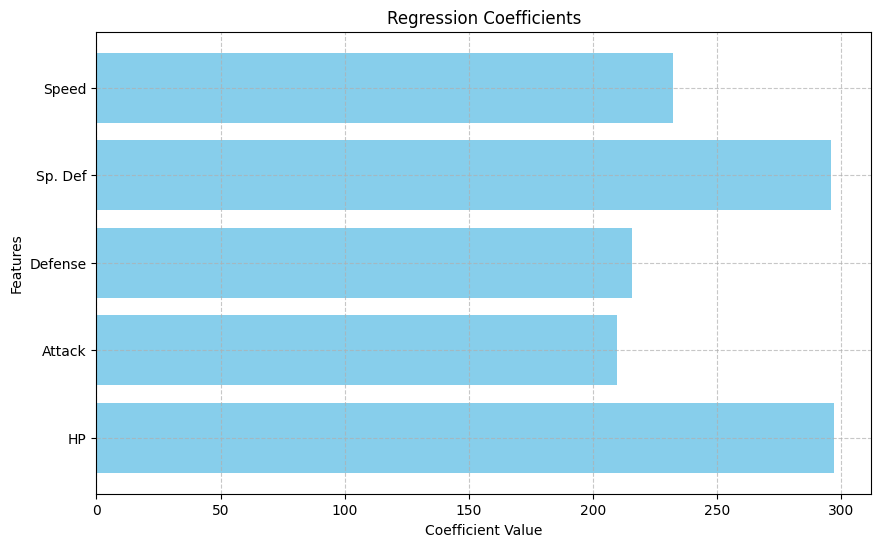

In [67]:
# Сначала выполним линейную регрессию
model, X_train, X_test, y_train, y_test = resolve_regression(X_selected_rfe, y_selected_rfe)

# Визуализация коэффициентов регрессии
plot_regression_coefficients(model, X_selected_rfe.columns)


## Пару слов про метрики

In [68]:
# Предсказание на тестовой выборке
y_pred = model.predict(X_test)

# Вычисление метрик качества
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Вывод метрик
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")


Mean Absolute Error (MAE): 19.36
Mean Squared Error (MSE): 636.77
R^2 Score: 0.95


Про метрики качества в регресии - https://education.yandex.ru/handbook/ml/article/metriki-klassifikacii-i-regressii#regressiya

## Регуляризация

In [69]:
X

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,45,49,49,65,65,45,1,False
1,60,62,63,80,80,60,1,False
2,80,82,83,100,100,80,1,False
3,80,100,123,122,120,80,1,False
4,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...
795,50,100,150,100,150,50,6,True
796,50,160,110,160,110,110,6,True
797,80,110,60,150,130,70,6,True
798,80,160,60,170,130,80,6,True


Про регуляризацию - https://yandex.ru/q/datascience/10672717313/

1. **L1-регуляризация (Lasso)**:
   Формула для L1-регуляризации добавляет штраф, который равен сумме абсолютных значений весов модели. Это может привести к обнулению некоторых весов, то есть к выбору только наиболее значимых признаков.

   Формула для L1-регуляризации:
   J(θ) = Функция потерь + λ * Σ|θ_i|

   где:
   - J(θ) — общая функция потерь с регуляризацией,
   - Функция потерь — это функция, измеряющая ошибку модели (например, среднеквадратическая ошибка),
   - λ — коэффициент регуляризации, который контролирует степень штрафа,
   - Σ|θ_i| — сумма абсолютных значений всех весов модели (θ_i).

2. **L2-регуляризация (Ridge)**:
   Формула для L2-регуляризации добавляет штраф, который равен сумме квадратов весов модели. Это не обнуляет веса, но снижает их величину, что приводит к более простым и менее подверженным переобучению моделям.

   Формула для L2-регуляризации:
   J(θ) = Функция потерь + λ * Σθ_i^2

   где:
   - J(θ) — общая функция потерь с регуляризацией,
   - Σθ_i^2 — сумма квадратов всех весов модели (θ_i).

3. **Elastic Net**:
   Это комбинированный метод, который использует и L1-штраф, и L2-штраф. Он полезен, когда нужно балансировать преимущества обоих методов.

   Формула для Elastic Net:
   J(θ) = Функция потерь + λ_1 * Σ|θ_i| + λ_2 * Σθ_i^2

   где:
   - λ_1 и λ_2 — коэффициенты регуляризации для L1 и L2 частей соответственно.

Регуляризация помогает улучшить обобщающую способность модели и предотвращает её переобучение.

Regularization: l1
Mean Absolute Error (MAE): 0.04
Mean Squared Error (MSE): 0.00
R^2 Score: 1.00


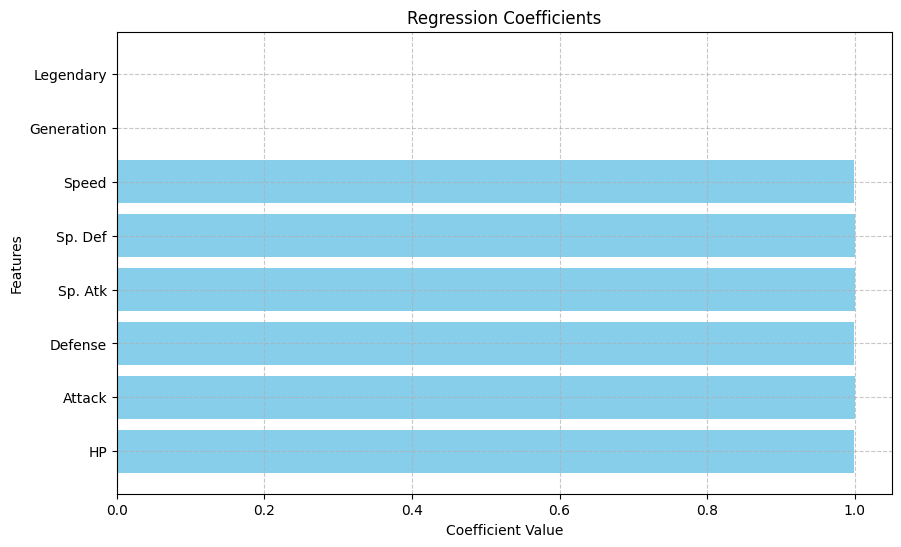

In [70]:
# L1-регуляризация
model, _, _, _, _ = resolve_regression(X, y, regularization='l1')
None

# Визуализация коэффициентов регрессии
plot_regression_coefficients(model, X.columns)


Regularization: l2
Mean Absolute Error (MAE): 0.00
Mean Squared Error (MSE): 0.00
R^2 Score: 1.00


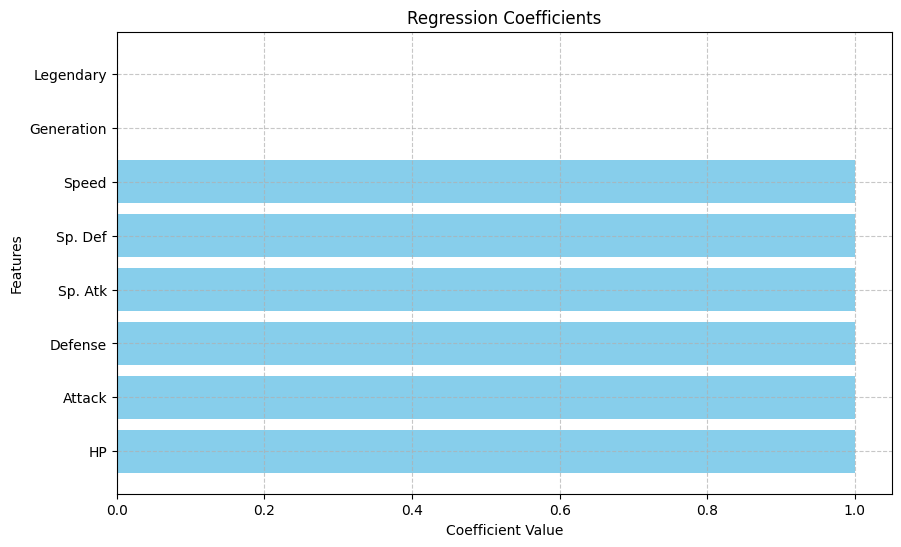

In [71]:
# L2-регуляризация
model, _, _, _, _ = resolve_regression(X, y, regularization='l2')
None

# Визуализация коэффициентов регрессии
plot_regression_coefficients(model, X.columns)

Regularization: None
Mean Absolute Error (MAE): 0.00
Mean Squared Error (MSE): 0.00
R^2 Score: 1.00


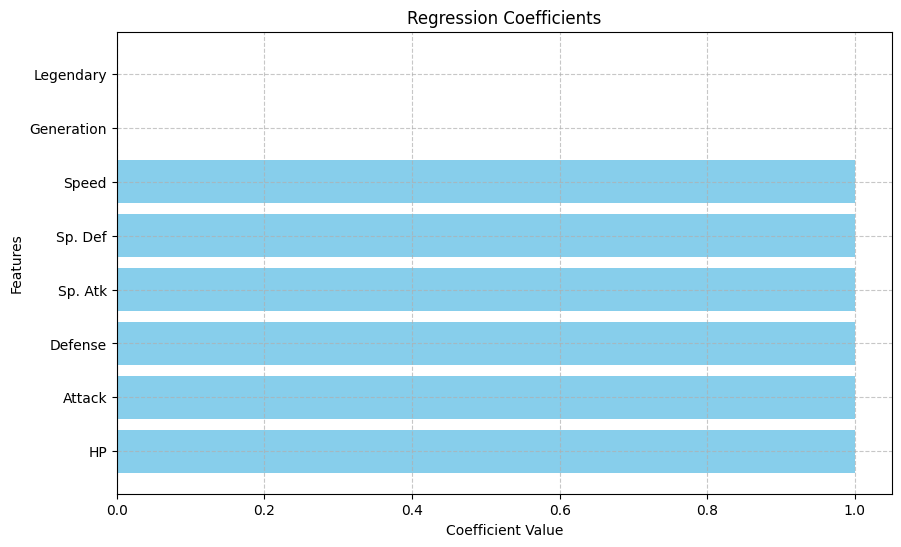

In [72]:
# Без регуляризации
model, _, _, _, _  = resolve_regression(X, y, regularization=None)
None
a = X.columns
# Визуализация коэффициентов регрессии
plot_regression_coefficients(model, a)


Так, ну что ж. Изначально я подумал, что модель переобучается, так как R2 очень высокая, постоянно стала равной 1. Но немного почитал, и понял. Так как я беру переменную total, которая буквально говорит об сумме HP, attack, deffence  и тд, эти переменные линейно зависимы. Из-за чего постоянно и выходит, что R2 = 1.0. Как можно посмотреть на последних графиках, например, Gen и Leg вообще не берутся в расчет.

Замечу, что 1.0 стало только после регулризации. MSE и MAE были довольно большими, говоря, что отклонения находятся в таких диапозонах. При помощи регуляризации мы же сказали модели "Мысли шире". И она как человек идущий к реке познала *смысл мироздания*, тобишь стала лучше обучаться. После регуляризации MAE и MSE стали либо нулевыми, либо близки к этому.

Но мне кажется, что модель всё-таки переобучена. Отсутствие ошибок и идеальная R2 буд-то бы говорят - ты скопировал и сравнил две одинаковых таблицы. Думаю, что модель, всё-таки переобучена. Слишком уж идеально быть не должно